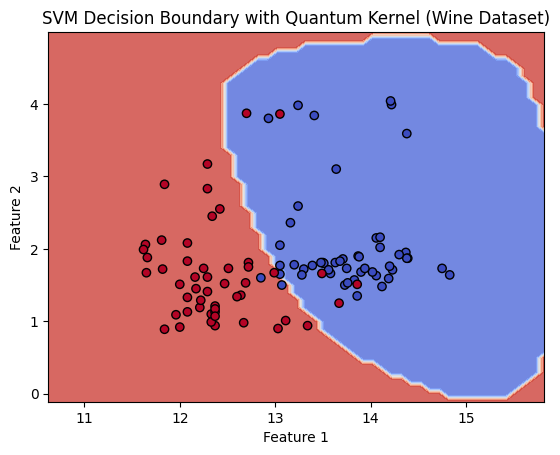

Classification accuracy: 0.90


In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.svm import SVC
from joblib import Parallel, delayed
import pennylane as qml
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# Load the Wine dataset
wine_data = load_wine()
features_wine = wine_data.data
labels_wine = wine_data.target

# Select samples from two classes only (class 0 and class 1)
class_0_wine = features_wine[labels_wine == 0][:50]  # First 50 samples of class 0
class_1_wine = features_wine[labels_wine == 1][:50]  # First 50 samples of class 1

# Combine the selected samples
features_wine = np.concatenate([class_0_wine, class_1_wine], axis=0)
labels_wine = np.array([0]*50 + [1]*50)

# Use only the first two features for visualization purposes
features_wine_2d = features_wine[:, :2]

# Define the number of qubits based on the reduced feature set (2 features)
num_qubits_wine = features_wine_2d.shape[1]
device_wine = qml.device('default.qubit', wires=num_qubits_wine)

# Define a simpler quantum feature map
def quantum_map_wine(x, params):
    for i in range(num_qubits_wine):
        qml.RY(x[i], wires=i)
    for i in range(num_qubits_wine):
        qml.RZ(params[i], wires=i)

# Define the variational quantum circuit
@qml.qnode(device_wine)
def variational_circuit_wine(x, params):
    quantum_map_wine(x, params)
    return qml.state()

# Function to compute the kernel matrix element
def kernel_element_wine(x1, x2, params):
    state_x1 = variational_circuit_wine(x1, params)
    state_x2 = variational_circuit_wine(x2, params)
    return np.abs(np.dot(np.conj(state_x1), state_x2))**2

# Function to compute the QEK matrix
def qek_matrix_wine(X, params):
    n_samples = len(X)
    qek_matrix = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            qek_matrix[i, j] = kernel_element_wine(X[i], X[j], params)

    return qek_matrix

# Kernel-target alignment function
def alignment_wine(params, X, y):
    qek_matrix = qek_matrix_wine(X, params)
    y_matrix = np.outer(y, y)
    alignment = np.sum(qek_matrix * y_matrix)
    return -alignment  # Negate for minimization

# Initialize random parameters
np.random.seed(42)
initial_params_wine = np.random.uniform(0, np.pi, num_qubits_wine)

# Optimize the parameters
result_wine = minimize(alignment_wine, initial_params_wine, args=(features_wine_2d, labels_wine), method='COBYLA')
optimized_params_wine = result_wine.x

# Compute the optimized QEK matrix
optimized_qek_matrix_wine = qek_matrix_wine(features_wine_2d, optimized_params_wine)

# Split the dataset into training and testing sets
features_train_wine, features_test_wine, labels_train_wine, labels_test_wine = train_test_split(features_wine_2d, labels_wine, test_size=0.2, random_state=42)

# Create a mesh to plot the decision boundary
h_wine = .1
x_min_wine, x_max_wine = features_wine_2d[:, 0].min() - 1, features_wine_2d[:, 0].max() + 1
y_min_wine, y_max_wine = features_wine_2d[:, 1].min() - 1, features_wine_2d[:, 1].max() + 1
xx_wine, yy_wine = np.meshgrid(np.arange(x_min_wine, x_max_wine, h_wine), np.arange(y_min_wine, y_max_wine, h_wine))
grid_points_wine = np.c_[xx_wine.ravel(), yy_wine.ravel()]

# Precompute the kernel matrix between the grid points and training data
def compute_grid_kernel_matrix_wine(grid_points, X_train, params):
    kernel_matrix = np.zeros((len(grid_points), len(X_train)))
    for i, grid_point in enumerate(grid_points):
        for j, x_train in enumerate(X_train):
            kernel_matrix[i, j] = kernel_element_wine(grid_point, x_train, params)
    return kernel_matrix

# Compute the kernel matrix for the grid points
grid_kernel_matrix_wine = compute_grid_kernel_matrix_wine(grid_points_wine, features_train_wine, optimized_params_wine)

# Compute the optimized kernel matrix for the reduced 2D training set
optimized_qek_matrix_train_wine = qek_matrix_wine(features_train_wine, optimized_params_wine)

# Train the SVM classifier on the 2D quantum kernel
svm_wine = SVC(kernel='precomputed')
svm_wine.fit(optimized_qek_matrix_train_wine, labels_train_wine)

# Predict the class for each point in the mesh using the precomputed kernel matrix
Z_wine = svm_wine.predict(grid_kernel_matrix_wine)
Z_wine = Z_wine.reshape(xx_wine.shape)

# Plot the decision boundary by assigning a color to each point in the mesh
plt.contourf(xx_wine, yy_wine, Z_wine, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(features_wine_2d[:, 0], features_wine_2d[:, 1], c=labels_wine, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary with Quantum Kernel (Wine Dataset)')
plt.show()
## Compute the kernel matrix for the test set using the function, not the array
K_test_wine = compute_grid_kernel_matrix_wine(features_test_wine, features_train_wine, optimized_params_wine)  # Call the function

# Evaluate the classifier's accuracy on the test set
accuracy_wine = svm_wine.score(K_test_wine, labels_test_wine)
print(f'Classification accuracy: {accuracy_wine:.2f}')